In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
!pip install torchmetrics
from torchmetrics.functional import accuracy, precision, recall, f1_score
from PIL import Image
import matplotlib.pyplot as plt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Custom Model

In [3]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lyr1 = nn.Linear(784, 392, bias=True)
        self.lyr2 = nn.Linear(392, 196, bias=True)
        self.lyr3 = nn.Linear(196, 98, bias=True)
        self.lyr4 = nn.Linear(98, 49, bias=True)
        self.lyr5 = nn.Linear(49, 24, bias=True)
        self.output = nn.Linear(24, 10, bias=True)

    def forward(self, x):
        x = F.relu(self.lyr1(x))
        x = F.relu(self.lyr2(x))
        x = F.relu(self.lyr3(x))
        x = F.relu(self.lyr4(x))
        x = F.relu(self.lyr5(x))
        output = F.relu(self.output(x))
        return output

# Hyperparameters

In [4]:
epoch = 50
batch_size = 32
num_workers = 2
shuffle = True
learning_rate = 0.01
train_size = 50000
val_size = 10000
test_size = 10000

In [5]:
dataset = MNIST(root="", download=True )
# Random_split can take both subclass of Dataset or np.ndarray etc anything.
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

test_dataset = MNIST(root="", train=False, download=False  )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 10454172.59it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 351444.95it/s]


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3189620.47it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4096887.91it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [6]:
print(type(train_dataset))
print(test_dataset[0])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

<class 'torch.utils.data.dataset.Subset'>
(<PIL.Image.Image image mode=L size=28x28 at 0x7EBF2733F3D0>, 7)
50000
10000
10000


In [7]:
img, label = train_dataset[0]
display(img)
print(type(label))
print(label)

<class 'int'>
7


In [8]:
# Custom collate is required here as we have images as PIL.Image.Image object.
# These can't be directly converted to tensor, We have to use do it via np.ndarray
# Tensor returned here are mounted on GPU (assuming VRAM will have enough to store the data in gpu)
def custom_collate(
    batch,
):
    """This is custom collate function"""
    imgs = torch.tensor(
        np.array([idv_data[0] for idv_data in batch]), dtype=torch.float32
    )
    label = torch.tensor([idv_data[1] for idv_data in batch], dtype=torch.int64)
    return imgs, label

# Training dataloader

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=custom_collate,
    pin_memory=True,
)

In [10]:
a = next(iter(train_dataloader))
print(a[0].shape)
print(type(a[0][0]))
print(a[0][0].dtype)
print(a[1].dtype)
print(a[1].shape)

torch.Size([32, 28, 28])
<class 'torch.Tensor'>
torch.float32
torch.int64
torch.Size([32])


# Training dataloader for evaluation metrices(without batching)

In [11]:
train_eval_imgs = torch.tensor(
    np.array([train_dataset[i][0] for i in range(len(train_dataset))]),
    dtype=torch.float32, device=device
)
train_eval_labels = torch.tensor(
    [train_dataset[i][1] for i in range(len(train_dataset))], dtype=torch.int64, device=device
)
train_eval_dataloader = (train_eval_imgs, train_eval_labels)

# Validation dataloader for evaluation metrices(without batching)

In [12]:
val_imgs = torch.tensor(
    np.array([val_dataset[i][0] for i in range(len(val_dataset))]), dtype=torch.float32, device=device
)
val_labels = torch.tensor(
    [val_dataset[i][1] for i in range(len(val_dataset))], dtype=torch.int64, device=device
)
val_dataloader = (val_imgs, val_labels)

In [13]:
print(val_dataloader[0].shape)

torch.Size([10000, 28, 28])


# Evaluation Class

In [22]:
class Metrices:
    def __init__(self):
        self.accuracy = 0
        self.recall = 0
        self.f1_score = 0
        self.precision = 0

        self.accuracy_list = []
        self.precision_list = []
        self.f1_score_list = []
        self.recall_list = []

    def __call__(self, y_pred, y_true):
        # As here each class label has equal weightage so type of average taken is macro.
        self.accuracy = accuracy(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.precision = precision(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.f1_score = f1_score(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.recall = recall(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()

        self.accuracy_list.append(self.accuracy)
        self.precision_list.append(self.precision)
        self.f1_score_list.append(self.f1_score)
        self.recall_list.append(self.recall)

In [23]:
no_of_pixels = torch.tensor(train_eval_dataloader[0][0].shape).prod().item()
print(no_of_pixels)

train_metrices = Metrices()
val_metrices = Metrices()

criterion = nn.CrossEntropyLoss()
model = CustomModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

784


# Training loop

In [24]:
for cur_epoch in range(epoch):
    for batch_x, batch_y_true in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y_true = batch_y_true.to(device)
        flat_batch_x = batch_x.view(-1, no_of_pixels)
        batch_y_pred = model(flat_batch_x)
        # batch_y_true is 1D and batch_y_pred 2D shape(batch_size,10).
        loss = criterion(
            batch_y_pred,
            batch_y_true,
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"\nEpoch [{cur_epoch+1}/{epoch}], Loss: {loss}")

    flat_train_eval_x = train_eval_dataloader[0].view((train_size, no_of_pixels))
    train_eval_y_pred = model(flat_train_eval_x)
    train_eval_y_true = train_eval_dataloader[1]
    train_metrices(train_eval_y_pred, train_eval_y_true)
    print("Train metrices:")
    print(
        f"Accuracy: {train_metrices.accuracy:.3f}, Precision: {train_metrices.precision:.3f}, Recall: {train_metrices.recall:.3f}, F1_Score: {train_metrices.f1_score:.3f}"
    )

    flat_val_x = val_dataloader[0].view((val_size, no_of_pixels))
    val_y_pred = model(flat_val_x)
    val_y_true = val_dataloader[1]
    val_metrices(val_y_pred, val_y_true)
    print("Validation metrices:")
    print(
        f"Accuracy: {val_metrices.accuracy:.3f}, Precision: {val_metrices.precision:.3f}, Recall: {val_metrices.recall:.3f}, F1_Score: {val_metrices.f1_score:.3f}"
    )


Epoch [1/50], Loss: 0.5191314220428467
Train metrices:
Accuracy: 0.963, Precision: 0.964, Recall: 0.963, F1_Score: 0.963
Validation metrices:
Accuracy: 0.959, Precision: 0.959, Recall: 0.959, F1_Score: 0.958

Epoch [2/50], Loss: 0.30280381441116333
Train metrices:
Accuracy: 0.970, Precision: 0.970, Recall: 0.970, F1_Score: 0.970
Validation metrices:
Accuracy: 0.962, Precision: 0.962, Recall: 0.962, F1_Score: 0.961

Epoch [3/50], Loss: 0.4351329803466797
Train metrices:
Accuracy: 0.971, Precision: 0.971, Recall: 0.971, F1_Score: 0.970
Validation metrices:
Accuracy: 0.961, Precision: 0.962, Recall: 0.961, F1_Score: 0.961

Epoch [4/50], Loss: 0.45245689153671265
Train metrices:
Accuracy: 0.980, Precision: 0.980, Recall: 0.980, F1_Score: 0.980
Validation metrices:
Accuracy: 0.969, Precision: 0.968, Recall: 0.969, F1_Score: 0.968

Epoch [5/50], Loss: 0.4545951783657074
Train metrices:
Accuracy: 0.983, Precision: 0.983, Recall: 0.983, F1_Score: 0.983
Validation metrices:
Accuracy: 0.969, Pr

# Training and Validation Plots

Text(0.5, 1.0, 'Metrices vs Epoch')

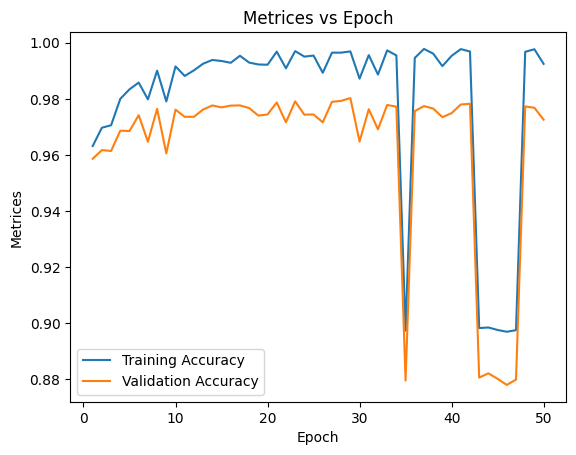

In [26]:
plt.plot(range(1, epoch + 1), train_metrices.accuracy_list, label="Training Accuracy")
plt.plot(range(1, epoch + 1), val_metrices.accuracy_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

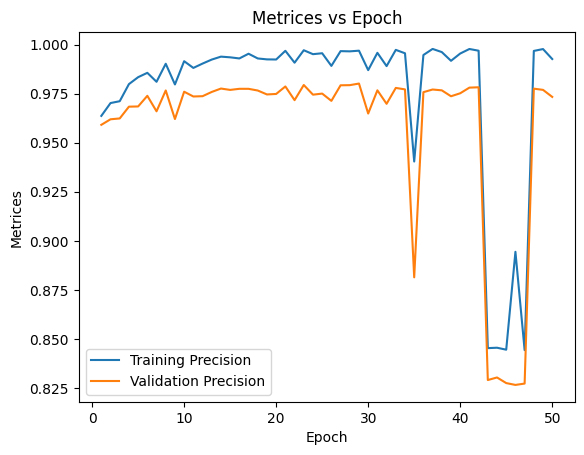

In [27]:
plt.plot(range(1, epoch + 1), train_metrices.precision_list, label="Training Precision")
plt.plot(range(1, epoch + 1), val_metrices.precision_list, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

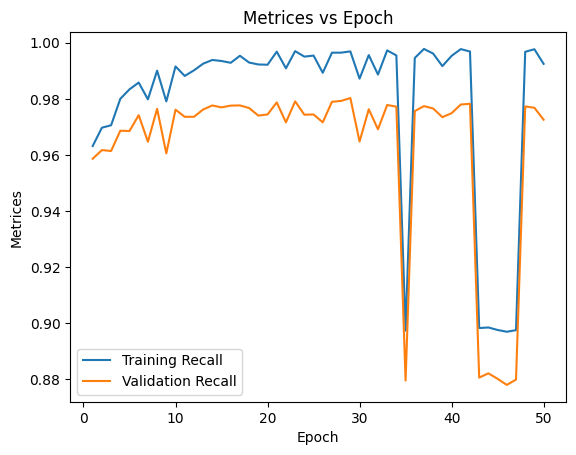

In [28]:
# Here recall is equal to accuracy as in MNIST dataset no of occurances of each class is same
plt.plot(range(1, epoch + 1), train_metrices.recall_list, label="Training Recall")
plt.plot(range(1, epoch + 1), val_metrices.recall_list, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

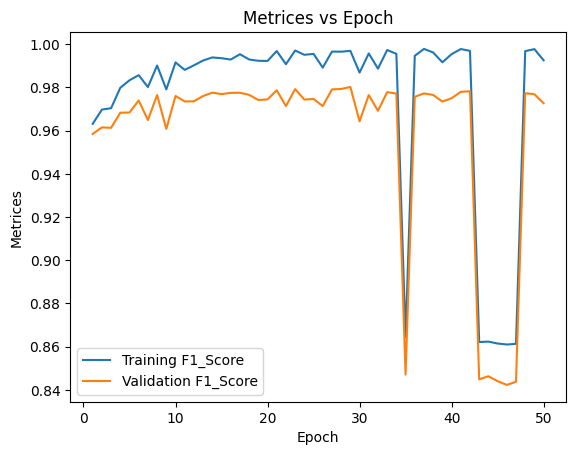

In [29]:
plt.plot(range(1, epoch + 1), train_metrices.f1_score_list, label="Training F1_Score")
plt.plot(range(1, epoch + 1), val_metrices.f1_score_list, label="Validation F1_Score")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

# Final Evaluation on test dataset

In [30]:
test_imgs = torch.tensor(
    np.array([test_dataset[i][0] for i in range(len(test_dataset))], dtype=np.float32), device=device
)
test_labels = torch.tensor(
    [test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.int64, device=device
)
test_dataloader = (test_imgs, test_labels)

In [31]:
flat_test_x = test_dataloader[0].view((test_size, no_of_pixels))
test_y_pred = model(flat_test_x)
test_y_true = test_dataloader[1]
test_metrices = Metrices()
test_metrices(test_y_pred, test_y_true)
print("\nFinal Evaluation Metrices:")
print(
    f"Accuracy: {test_metrices.accuracy:.3f}, Precision: {test_metrices.precision:.3f}, F1_Score: {test_metrices.f1_score:.3f}, Recall: {test_metrices.recall:.3f}"
)


Final Evaluation Metrices:
Accuracy: 0.975, Precision: 0.976, F1_Score: 0.975, Recall: 0.975
